Please upload one or more damaged car images.


Saving damage car .jpeg to damage car .jpeg
Processing damage car .jpeg...


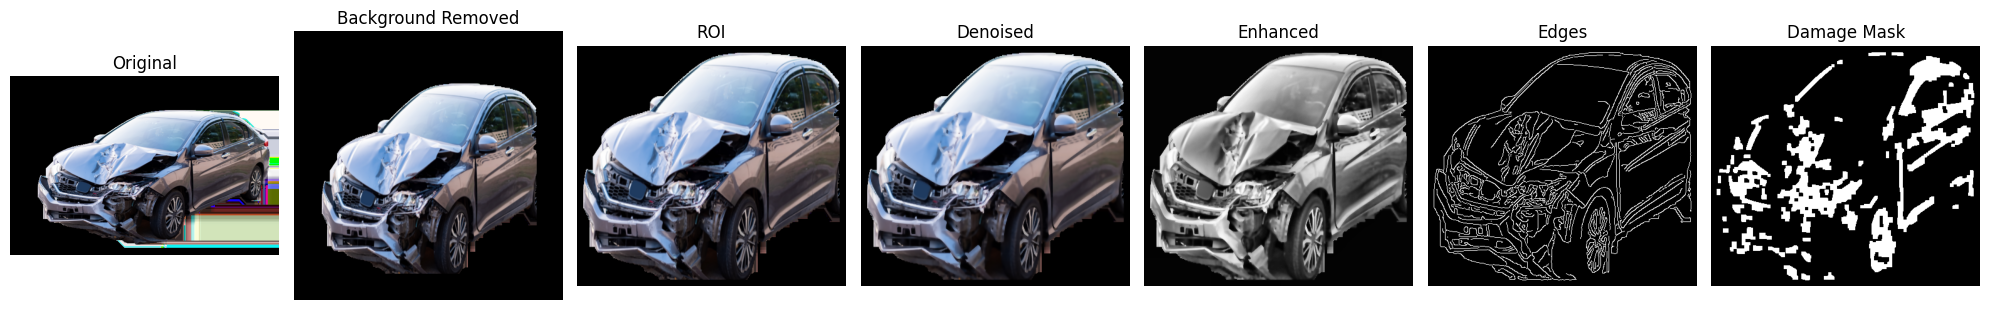

Image features:
  mean: 126.08474239108813
  std: 64.76904012769276
  min: 1
  max: 255
  histogram: [array with shape (256,)]
  gradient_mean: 65.55769030037615
  gradient_std: 164.2610499727185
  lbp_histogram: [3.500e+01 1.800e+01 3.000e+00 1.100e+01 2.300e+01 4.000e+00 1.100e+01
 5.900e+01 1.500e+01 1.000e+00 0.000e+00 0.000e+00 4.100e+01 8.000e+00
 3.300e+01 1.480e+02 3.600e+01 5.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 1.000e+00 4.700e+01 2.000e+00 0.000e+00 1.000e+00
 4.800e+01 5.000e+00 5.800e+01 4.900e+01 2.000e+00 3.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 6.000e+00 5.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.800e+01 1.000e+00 1.000e+00 0.000e+00 2.800e+01 0.000e+00 3.900e+01
 1.800e+01 1.400e+01 1.000e+00 0.000e+00 1.000e+00 2.000e+00 0.000e+00
 2.000e+00 3.000e+00 2.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00
 0.000

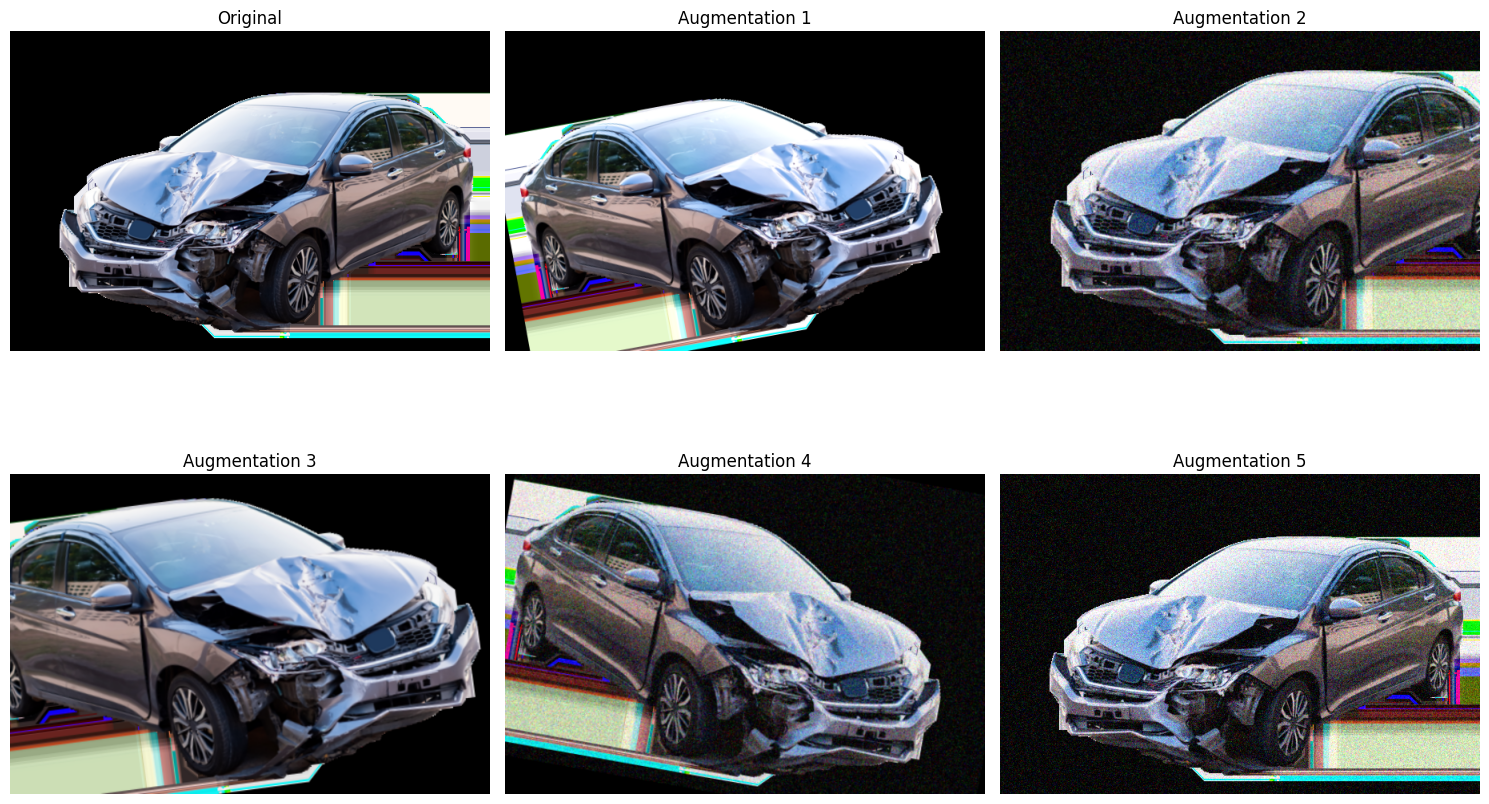

In [ ]:


# Install necessary dependencies
!pip install -q opencv-python-headless
!pip install -q matplotlib
!pip install -q numpy
!pip install -q scikit-image
!pip install -q tensorflow
!pip install -q albumentations

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from sklearn.cluster import KMeans
from skimage import exposure, filters, color
import random
from typing import List, Tuple, Dict, Any, Optional
import glob
import time

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

class CarDamagePreprocessor:
    """
    A class for preprocessing damaged car images to prepare them for damage detection
    and classification models.
    """

    def __init__(self,
                 target_size: Tuple[int, int] = (512, 512),
                 normalize: bool = True,
                 clahe_clip_limit: float = 2.0,
                 clahe_grid_size: Tuple[int, int] = (8, 8)):
        """
        Initialize the damaged car image preprocessor.

        Args:
            target_size: Output size for processed images (height, width)
            normalize: Whether to normalize pixel values to [0,1]
            clahe_clip_limit: Clip limit for CLAHE contrast enhancement
            clahe_grid_size: Grid size for CLAHE contrast enhancement
        """
        self.target_size = target_size
        self.normalize = normalize
        self.clahe = cv2.createCLAHE(clipLimit=clahe_clip_limit,
                                    tileGridSize=clahe_grid_size)

    def load_image(self, image_path: str) -> np.ndarray:
        """
        Load an image from a file path.

        Args:
            image_path: Path to the image file

        Returns:
            The loaded image as a numpy array
        """
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Failed to load image from {image_path}")
        return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    def standardize_image(self, image: np.ndarray) -> np.ndarray:
        """
        Resize and standardize an image.

        Args:
            image: Input image as numpy array

        Returns:
            Standardized image
        """
        # Resize to target size
        resized = cv2.resize(image, (self.target_size[1], self.target_size[0]))

        # Normalize pixel values if requested
        if self.normalize:
            return resized.astype(np.float32) / 255.0
        return resized

    def remove_background(self, image: np.ndarray,
                          threshold: int = 25,
                          blur_size: int = 5) -> Tuple[np.ndarray, np.ndarray]:
        """
        Remove the background from a car image to focus on the vehicle.
        Uses GrabCut algorithm for automatic foreground extraction.

        Args:
            image: Input image as numpy array
            threshold: Threshold for background removal
            blur_size: Size of the blur kernel for preprocessing

        Returns:
            Tuple of (processed image with background removed, mask)
        """
        # Create a copy of the image
        img = image.copy()

        # Convert to RGB if needed
        if len(img.shape) == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

        # Ensure image is uint8 for GrabCut (required by OpenCV)
        if img.dtype == np.float32:
            img = (img * 255).astype(np.uint8)
        elif img.dtype != np.uint8:
            img = img.astype(np.uint8)

        # Initial mask creation
        mask = np.zeros(img.shape[:2], np.uint8)

        # Background and foreground models
        bgd_model = np.zeros((1, 65), np.float64)
        fgd_model = np.zeros((1, 65), np.float64)

        # Define rough ROI around the image center assuming car is in the middle
        margin = 50
        rect = (margin, margin, img.shape[1]-2*margin, img.shape[0]-2*margin)

        try:
            # Apply GrabCut
            cv2.grabCut(img, mask, rect, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_RECT)

            # Convert mask
            mask2 = np.where((mask==2) | (mask==0), 0, 1).astype('uint8')
        except cv2.error:
            # Fallback if GrabCut fails
            print("GrabCut failed. Using basic thresholding as fallback.")
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            blurred = cv2.GaussianBlur(gray, (blur_size, blur_size), 0)
            _, mask2 = cv2.threshold(blurred, threshold, 1, cv2.THRESH_BINARY)

        # Apply the mask to the image
        result = img * mask2[:, :, np.newaxis]

        # Convert back to original format if needed
        if image.dtype == np.float32:
            result = result.astype(np.float32) / 255.0

        return result, mask2

    def detect_roi(self, image: np.ndarray,
                   mask: Optional[np.ndarray] = None) -> Tuple[np.ndarray, Tuple[int, int, int, int]]:
        """
        Detect the region of interest (ROI) containing the damaged car.

        Args:
            image: Input image
            mask: Optional mask from background removal

        Returns:
            Tuple of (cropped image containing ROI, bounding box coordinates)
        """
        # If mask is provided, use it to find contours
        if mask is not None:
            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            if contours:
                # Find the largest contour (assumed to be the car)
                largest_contour = max(contours, key=cv2.contourArea)
                x, y, w, h = cv2.boundingRect(largest_contour)

                # Add some padding
                padding = 10
                x = max(0, x - padding)
                y = max(0, y - padding)
                w = min(image.shape[1] - x, w + 2*padding)
                h = min(image.shape[0] - y, h + 2*padding)

                # Crop the image to the bounding box
                cropped = image[y:y+h, x:x+w]
                return cropped, (x, y, w, h)

        # If no mask or no contours found, use edge detection as fallback
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) if len(image.shape) > 2 else image
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        edges = cv2.Canny(blurred, 50, 150)

        # Find contours in the edge map
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            # Combine all contours to find the overall bounding box
            all_points = np.concatenate([cnt for cnt in contours])
            x, y, w, h = cv2.boundingRect(all_points)

            # Add some padding
            padding = 20
            x = max(0, x - padding)
            y = max(0, y - padding)
            w = min(image.shape[1] - x, w + 2*padding)
            h = min(image.shape[0] - y, h + 2*padding)

            # Crop the image to the bounding box
            cropped = image[y:y+h, x:x+w]
            return cropped, (x, y, w, h)

        # If all else fails, return the original image
        return image, (0, 0, image.shape[1], image.shape[0])

    def reduce_noise(self, image: np.ndarray,
                     method: str = 'gaussian',
                     kernel_size: int = 5) -> np.ndarray:
        """
        Apply noise reduction to an image.

        Args:
            image: Input image
            method: Noise reduction method ('gaussian', 'median', 'bilateral')
            kernel_size: Size of the kernel for noise reduction

        Returns:
            Noise-reduced image
        """
        if method == 'gaussian':
            return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
        elif method == 'median':
            return cv2.medianBlur(image, kernel_size)
        elif method == 'bilateral':
            if len(image.shape) > 2 and image.dtype == np.float32:
                # Convert to 8-bit for bilateral filter
                temp = (image * 255).astype(np.uint8)
                result = cv2.bilateralFilter(temp, kernel_size, 75, 75)
                return result.astype(np.float32) / 255.0
            else:
                return cv2.bilateralFilter(image, kernel_size, 75, 75)
        else:
            raise ValueError(f"Unknown noise reduction method: {method}")

    def enhance_contrast(self, image: np.ndarray,
                         method: str = 'clahe') -> np.ndarray:
        """
        Enhance contrast in an image to make damage more visible.

        Args:
            image: Input image
            method: Contrast enhancement method ('clahe', 'histeq', 'adapthist')

        Returns:
            Contrast-enhanced image
        """
        # Convert to grayscale if image is RGB
        if len(image.shape) > 2:
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        else:
            gray = image.copy()

        # Scale to 0-255 if normalized
        if gray.dtype == np.float32:
            gray = (gray * 255).astype(np.uint8)

        if method == 'clahe':
            enhanced = self.clahe.apply(gray)
        elif method == 'histeq':
            enhanced = cv2.equalizeHist(gray)
        elif method == 'adapthist':
            enhanced = exposure.equalize_adapthist(gray, clip_limit=0.03)
            enhanced = (enhanced * 255).astype(np.uint8)
        else:
            raise ValueError(f"Unknown contrast enhancement method: {method}")

        # If input was RGB, convert back to RGB
        if len(image.shape) > 2:
            # Create a 3-channel image where each channel has the enhanced data
            enhanced_rgb = np.zeros_like(image)
            if image.dtype == np.float32:
                enhanced_rgb[:,:,0] = enhanced.astype(np.float32) / 255.0
                enhanced_rgb[:,:,1] = enhanced.astype(np.float32) / 255.0
                enhanced_rgb[:,:,2] = enhanced.astype(np.float32) / 255.0
            else:
                enhanced_rgb[:,:,0] = enhanced
                enhanced_rgb[:,:,1] = enhanced
                enhanced_rgb[:,:,2] = enhanced
            return enhanced_rgb

        # Return the enhanced grayscale image
        if image.dtype == np.float32:
            return enhanced.astype(np.float32) / 255.0
        return enhanced

    def detect_edges(self, image: np.ndarray,
                     method: str = 'canny',
                     low_threshold: int = 50,
                     high_threshold: int = 150) -> np.ndarray:
        """
        Detect edges in an image to highlight damage areas.

        Args:
            image: Input image
            method: Edge detection method ('canny', 'sobel', 'scharr')
            low_threshold: Low threshold for Canny edge detection
            high_threshold: High threshold for Canny edge detection

        Returns:
            Edge map
        """
        # Convert to grayscale if image is RGB
        if len(image.shape) > 2:
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        else:
            gray = image.copy()

        # Scale to 0-255 if normalized
        if gray.dtype == np.float32:
            gray = (gray * 255).astype(np.uint8)

        # Apply Gaussian blur to reduce noise
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)

        if method == 'canny':
            edges = cv2.Canny(blurred, low_threshold, high_threshold)
        elif method == 'sobel':
            sobelx = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=3)
            sobely = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=3)
            edges = np.sqrt(sobelx**2 + sobely**2)
            edges = cv2.normalize(edges, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
        elif method == 'scharr':
            scharrx = cv2.Scharr(blurred, cv2.CV_64F, 1, 0)
            scharry = cv2.Scharr(blurred, cv2.CV_64F, 0, 1)
            edges = np.sqrt(scharrx**2 + scharry**2)
            edges = cv2.normalize(edges, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
        else:
            raise ValueError(f"Unknown edge detection method: {method}")

        # Return the edge map
        if image.dtype == np.float32:
            return edges.astype(np.float32) / 255.0
        return edges

    def segment_damage(self, image: np.ndarray,
                       edge_map: np.ndarray = None,
                       threshold: float = 0.3) -> np.ndarray:
        """
        Simple damage segmentation based on edge information.
        This is a basic approach that can be refined with ML techniques.

        Args:
            image: Input image
            edge_map: Edge map from edge detection
            threshold: Threshold for damage segmentation

        Returns:
            Mask highlighting potential damage areas
        """
        if edge_map is None:
            edge_map = self.detect_edges(image)

        # Threshold the edge map to get binary mask
        if edge_map.dtype == np.float32:
            mask = (edge_map > threshold).astype(np.uint8)
        else:
            mask = (edge_map > threshold * 255).astype(np.uint8)

        # Apply morphological operations to clean up the mask
        kernel = np.ones((5, 5), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

        # Label connected components
        num_labels, labels = cv2.connectedComponents(mask)

        # Filter out small regions
        min_size = 50
        for i in range(1, num_labels):
            if np.sum(labels == i) < min_size:
                mask[labels == i] = 0

        return mask

    def extract_features(self, image: np.ndarray,
                         mask: Optional[np.ndarray] = None) -> Dict[str, Any]:
        """
        Extract features from the image for damage analysis.

        Args:
            image: Input image
            mask: Optional mask to focus on specific regions

        Returns:
            Dictionary of extracted features
        """
        # Convert to grayscale if image is RGB
        if len(image.shape) > 2:
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        else:
            gray = image.copy()

        # Apply mask if provided
        if mask is not None:
            masked_gray = cv2.bitwise_and(gray, gray, mask=mask)
        else:
            masked_gray = gray

        # Scale to 0-255 if normalized
        if masked_gray.dtype == np.float32:
            masked_gray = (masked_gray * 255).astype(np.uint8)

        # Extract features
        features = {}

        # Basic statistics
        if np.any(masked_gray > 0):
            features['mean'] = np.mean(masked_gray[masked_gray > 0])
            features['std'] = np.std(masked_gray[masked_gray > 0])
            features['min'] = np.min(masked_gray[masked_gray > 0])
            features['max'] = np.max(masked_gray[masked_gray > 0])
        else:
            features['mean'] = 0
            features['std'] = 0
            features['min'] = 0
            features['max'] = 0

        # Histogram
        hist = cv2.calcHist([masked_gray], [0], None, [256], [0, 256])
        features['histogram'] = hist.flatten()

        # Texture features using Haralick texture features (calculated manually)
        if np.any(masked_gray > 0):
            # Convert to uint8 for texture analysis
            masked_gray_uint8 = masked_gray.astype(np.uint8)

            # Calculate gradient magnitude as a simple texture feature
            sobelx = cv2.Sobel(masked_gray_uint8, cv2.CV_64F, 1, 0, ksize=3)
            sobely = cv2.Sobel(masked_gray_uint8, cv2.CV_64F, 0, 1, ksize=3)
            gradient_magnitude = np.sqrt(sobelx**2 + sobely**2)

            features['gradient_mean'] = np.mean(gradient_magnitude)
            features['gradient_std'] = np.std(gradient_magnitude)

            # Calculate local binary pattern (simple version)
            def local_binary_pattern(image, points=8, radius=1):
                rows, cols = image.shape
                result = np.zeros((rows-2*radius, cols-2*radius), dtype=np.uint8)
                for i in range(radius, rows-radius):
                    for j in range(radius, cols-radius):
                        center = image[i, j]
                        pattern = 0
                        for p in range(points):
                            angle = 2 * np.pi * p / points
                            x = j + int(round(radius * np.cos(angle)))
                            y = i + int(round(radius * np.sin(angle)))
                            if image[y, x] >= center:
                                pattern |= (1 << p)
                        result[i-radius, j-radius] = pattern
                return result

            try:
                # Only compute LBP on a smaller region if image is large
                if masked_gray_uint8.shape[0] > 100 and masked_gray_uint8.shape[1] > 100:
                    center_y, center_x = masked_gray_uint8.shape[0] // 2, masked_gray_uint8.shape[1] // 2
                    roi_size = 50
                    roi = masked_gray_uint8[
                        max(0, center_y - roi_size):min(masked_gray_uint8.shape[0], center_y + roi_size),
                        max(0, center_x - roi_size):min(masked_gray_uint8.shape[1], center_x + roi_size)
                    ]
                    lbp = local_binary_pattern(roi)
                else:
                    lbp = local_binary_pattern(masked_gray_uint8)

                lbp_hist = cv2.calcHist([lbp], [0], None, [256], [0, 256])
                features['lbp_histogram'] = lbp_hist.flatten()
                features['lbp_entropy'] = -np.sum((lbp_hist / np.sum(lbp_hist)) *
                                                 np.log2(lbp_hist / np.sum(lbp_hist) + 1e-10))
            except Exception as e:
                print(f"LBP calculation error: {e}")
                features['lbp_histogram'] = np.zeros(256)
                features['lbp_entropy'] = 0
        else:
            features['gradient_mean'] = 0
            features['gradient_std'] = 0
            features['lbp_histogram'] = np.zeros(256)
            features['lbp_entropy'] = 0

        # SIFT features (keypoints)
        try:
            if np.any(masked_gray > 0):
                sift = cv2.SIFT_create()
                keypoints, descriptors = sift.detectAndCompute(masked_gray, None)
                features['num_keypoints'] = len(keypoints)
                features['keypoints'] = keypoints
                features['descriptors'] = descriptors if descriptors is not None else np.array([])
            else:
                features['num_keypoints'] = 0
                features['keypoints'] = []
                features['descriptors'] = np.array([])
        except Exception as e:
            print(f"SIFT feature extraction error: {e}")
            features['num_keypoints'] = 0
            features['keypoints'] = []
            features['descriptors'] = np.array([])

        return features

    def augment_data(self, image: np.ndarray,
                     num_augmentations: int = 5) -> List[np.ndarray]:
        """
        Generate augmented versions of the input image for training.

        Args:
            image: Input image
            num_augmentations: Number of augmented images to generate

        Returns:
            List of augmented images
        """
        augmented_images = []

        # Define some augmentation functions
        def random_brightness_contrast(img, brightness_range=(-0.2, 0.2), contrast_range=(-0.2, 0.2)):
            # Brightness adjustment
            brightness = np.random.uniform(brightness_range[0], brightness_range[1])
            adjusted = img.astype(np.float32) + brightness

            # Contrast adjustment
            contrast = np.random.uniform(contrast_range[0], contrast_range[1]) + 1.0
            adjusted = adjusted * contrast

            # Clip values to valid range
            adjusted = np.clip(adjusted, 0, 1.0 if img.dtype == np.float32 else 255)
            return adjusted.astype(img.dtype)

        def random_noise(img, var=0.01):
            # Add Gaussian noise
            if img.dtype == np.float32:
                noise = np.random.normal(0, var**0.5, img.shape)
                noisy = img + noise
                return np.clip(noisy, 0, 1.0).astype(np.float32)
            else:
                noise = np.random.normal(0, var**0.5 * 255, img.shape).astype(np.int16)
                noisy = img.astype(np.int16) + noise
                return np.clip(noisy, 0, 255).astype(np.uint8)

        def random_rotation(img, angle_range=(-15, 15)):
            # Random rotation
            angle = np.random.uniform(angle_range[0], angle_range[1])
            rows, cols = img.shape[:2]
            M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
            return cv2.warpAffine(img, M, (cols, rows))

        def random_flip(img):
            # Random horizontal flip
            if np.random.random() > 0.5:
                return cv2.flip(img, 1)
            return img

        def random_crop(img, crop_factor_range=(0.8, 0.95)):
            factor = np.random.uniform(crop_factor_range[0], crop_factor_range[1])
            h, w = img.shape[:2]
            crop_h, crop_w = int(h * factor), int(w * factor)
            start_h = np.random.randint(0, h - crop_h + 1)
            start_w = np.random.randint(0, w - crop_w + 1)
            cropped = img[start_h:start_h+crop_h, start_w:start_w+crop_w]
            return cv2.resize(cropped, (w, h))

        # Define augmentation pipeline with probabilities
        augmentation_functions = [
            (random_brightness_contrast, 0.7),
            (random_noise, 0.5),
            (random_rotation, 0.5),
            (random_flip, 0.5),
            (random_crop, 0.5)
        ]

        for _ in range(num_augmentations):
            # Start with a copy of the original image
            augmented = image.copy()

            # Apply random augmentations based on probability
            for aug_func, prob in augmentation_functions:
                if np.random.random() < prob:
                    augmented = aug_func(augmented)

            augmented_images.append(augmented)

        return augmented_images

    def visualize_preprocessing(self, original: np.ndarray,
                               processed_results: Dict[str, np.ndarray]) -> None:
        """
        Visualize the preprocessing steps.

        Args:
            original: Original image
            processed_results: Dictionary of processed images
        """
        # Determine number of steps
        n_steps = len(processed_results) + 1  # +1 for original

        # Create figure with subplots
        fig, axes = plt.subplots(1, n_steps, figsize=(20, 5))

        # Plot original image
        axes[0].imshow(original)
        axes[0].set_title('Original')
        axes[0].axis('off')

        # Plot processed results
        for i, (title, img) in enumerate(processed_results.items(), 1):
            # Handle different image types
            if len(img.shape) == 2:  # Grayscale or mask
                if img.dtype == bool:
                    img = img.astype(np.uint8) * 255

                # Display as grayscale
                axes[i].imshow(img, cmap='gray')
            else:
                # Display as RGB
                if img.dtype == np.float32 and np.max(img) <= 1.0:
                    axes[i].imshow(img)
                else:
                    axes[i].imshow(img.astype(np.uint8))

            axes[i].set_title(title)
            axes[i].axis('off')

        plt.tight_layout()
        plt.show()

    def process_image(self, image: np.ndarray,
                      visualize: bool = False) -> Dict[str, Any]:
        """
        Process a single image through the entire pipeline.

        Args:
            image: Input image
            visualize: Whether to visualize the preprocessing steps

        Returns:
            Dictionary of processed images and features
        """
        results = {}

        # Standardize image
        std_image = self.standardize_image(image)
        results['standardized'] = std_image

        # Remove background
        bg_removed, mask = self.remove_background(std_image)
        results['background_removed'] = bg_removed
        results['background_mask'] = mask

        # Detect ROI
        roi, bbox = self.detect_roi(bg_removed, mask)
        results['roi'] = roi
        results['bbox'] = bbox

        # Reduce noise
        denoised = self.reduce_noise(roi, method='bilateral')
        results['denoised'] = denoised

        # Enhance contrast
        enhanced = self.enhance_contrast(denoised)
        results['enhanced'] = enhanced

        # Detect edges
        edges = self.detect_edges(enhanced)
        results['edges'] = edges

        # Segment damage
        damage_mask = self.segment_damage(enhanced, edges)
        results['damage_mask'] = damage_mask

        # Extract features
        features = self.extract_features(enhanced, damage_mask)
        results['features'] = features

        # Visualize if requested
        if visualize:
            vis_results = {
                'Background Removed': bg_removed,
                'ROI': roi,
                'Denoised': denoised,
                'Enhanced': enhanced,
                'Edges': edges,
                'Damage Mask': damage_mask
            }
            self.visualize_preprocessing(image, vis_results)

        return results

    def process_directory(self, directory_path: str,
                         output_dir: str = None,
                         visualize: bool = False) -> Dict[str, Dict[str, Any]]:
        """
        Process all images in a directory.

        Args:
            directory_path: Path to directory containing images
            output_dir: Path to directory to save processed images
            visualize: Whether to visualize the preprocessing steps

        Returns:
            Dictionary mapping image filenames to processing results
        """
        # Create output directory if specified
        if output_dir is not None:
            os.makedirs(output_dir, exist_ok=True)

        results = {}

        # Get all image files
        image_files = []
        for ext in ['*.jpg', '*.jpeg', '*.png', '*.bmp']:
            image_files.extend(glob.glob(os.path.join(directory_path, ext)))
            image_files.extend(glob.glob(os.path.join(directory_path, ext.upper())))

        print(f"Found {len(image_files)} images in {directory_path}")

        # Process each image
        for image_file in image_files:
            try:
                # Load image
                image = self.load_image(image_file)

                # Process image
                result = self.process_image(image, visualize=visualize)

                # Save processed images if output directory is specified
                if output_dir is not None:
                    # Get base filename without extension
                    basename = os.path.splitext(os.path.basename(image_file))[0]

                    # Save each processed image
                    for name, img in result.items():
                        if isinstance(img, np.ndarray):
                            # Create image file path
                            img_path = os.path.join(output_dir, f"{basename}_{name}.png")

                            # Convert to uint8 if needed
                            if img.dtype == np.float32:
                                img = (img * 255).astype(np.uint8)

                            # Save the image
                            if len(img.shape) == 2:
                                cv2.imwrite(img_path, img)
                            else:
                                cv2.imwrite(img_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

                # Store results
                results[os.path.basename(image_file)] = result

            except Exception as e:
                print(f"Error processing {image_file}: {e}")

        return results

# Example usage
def main():
    """
    Example usage of the CarDamagePreprocessor.
    """
    # Create preprocessor
    preprocessor = CarDamagePreprocessor()

    # Check if images already exist in the environment
    import os
    existing_images = [f for f in os.listdir() if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]

    if existing_images:
        print(f"Found {len(existing_images)} images in the current directory.")
        image_files = existing_images
    else:
        # Allow user to upload images
        print("Please upload one or more damaged car images.")
        uploaded = files.upload()
        image_files = list(uploaded.keys())

    # Process images
    for filename in image_files:
        try:
            print(f"Processing {filename}...")

            # Load image
            image = cv2.imread(filename)
            if image is None:
                print(f"Error: Could not read image {filename}")
                continue

            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Process image with error handling
            try:
                result = preprocessor.process_image(image, visualize=True)

                # Display features
                print(f"Image features:")
                for key, value in result['features'].items():
                    if key in ['histogram', 'keypoints', 'descriptors']:
                        if isinstance(value, np.ndarray):
                            print(f"  {key}: [array with shape {value.shape}]")
                        else:
                            print(f"  {key}: [array with {len(value)} elements]")
                    else:
                        print(f"  {key}: {value}")

                print("\n")

                # Demonstrate augmentation with the first successful image
                print("Generating data augmentations...")
                augmented_images = preprocessor.augment_data(image, num_augmentations=5)

                # Display augmented images
                plt.figure(figsize=(15, 10))
                plt.subplot(2, 3, 1)
                plt.imshow(image)
                plt.title("Original")
                plt.axis('off')

                for i, aug_img in enumerate(augmented_images, 1):
                    plt.subplot(2, 3, i+1)
                    plt.imshow(aug_img)
                    plt.title(f"Augmentation {i}")
                    plt.axis('off')

                plt.tight_layout()
                plt.show()

                # Only process one image for demonstration
                break

            except Exception as e:
                print(f"Error during image processing: {str(e)}")
                import traceback
                traceback.print_exc()

        except Exception as e:
            print(f"Error with image {filename}: {str(e)}")
            import traceback
            traceback.print_exc()

if __name__ == "__main__":
    main()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')